In [96]:
from math import floor
import math 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb
from scipy.stats import mode
import os

In [117]:
"En este apartado se obtiene los bbordes por medio de Laplace "
# función para aplicar una convolución 2D a una imagen
def convolucion_2d(imagen, kernel):
    alto, ancho = imagen.shape
    k_alto, k_ancho = kernel.shape
        # cálculo del borde para evitar desbordamiento
    bordeH = int((k_alto-1)/2)
    bordeW = int((k_ancho-1)/2)
    
    imagen_ampliada = np.zeros((alto + bordeH*2, ancho + bordeW*2))
    imagen_ampliada[bordeH:-bordeH, bordeW:-bordeW] = imagen
    resultado = np.zeros_like(imagen)
    
    # aplicación del kernel a cada píxel de la imagen
    for i in range(bordeH, alto+bordeH):
        for j in range(bordeW, ancho+bordeW):
            trozo = imagen_ampliada[i-bordeH:i+bordeH+1, j-bordeW:j+bordeW+1]
            resultado[i-bordeH, j-bordeW] = (trozo * kernel).sum()
    
    return resultado

def convolucion(img, kernel):
    kernelint = floor(kernel.shape[0]/2)
    R, G, B = 0, 1, 2
    matrizExtendidaR = np.pad(img[:, :, R], kernelint, mode='constant')
    matrizExtendidaG = np.pad(img[:, :, G], kernelint, mode='constant')
    matrizExtendidaB = np.pad(img[:, :, B], kernelint, mode='constant')
    matrixRes = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    for i in range(kernelint, matrizExtendidaR.shape[0] - kernelint):
        for j in range(kernelint, matrizExtendidaR.shape[1] - kernelint):
            sumaR, sumaG, sumaB = 0, 0, 0
            for m in range(kernel.shape[0]):
                for n in range(kernel.shape[1]):
                    sumaR = sumaR + (kernel[m][n] * matrizExtendidaR[i-kernelint+m][j-kernelint+n])
                    sumaG = sumaG + (kernel[m][n] * matrizExtendidaG[i-kernelint+m][j-kernelint+n])
                    sumaB = sumaB + (kernel[m][n] * matrizExtendidaB[i-kernelint+m][j-kernelint+n])
            matrixRes[i-kernelint][j-kernelint][R] = round(sumaR)
            matrixRes[i-kernelint][j-kernelint][G] = round(sumaG)
            matrixRes[i-kernelint][j-kernelint][B] = round(sumaB)
    return matrixRes


# función para aplicar una umbralización a una imagen
def umbralizacion(imagen, umbral):
    resultado = np.zeros_like(imagen)
    resultado[imagen > umbral] = 255

    return resultado

def thresholdOtsu(img): #min(weightB*VarianceB + weightF*VarianceF)
    #Histogram
    hist = np.zeros(256)
    for row in range(img.shape[0]):
        for column in range(img.shape[1]):
            hist[img[row][column][0]] += 1
    
    pixelesInImg = img.shape[0]*img.shape[1]
    WCVList = []

    #Algorithm
    for threshold in range(len(hist)):
        #b where hist < threshold
        b = hist[:threshold]
        #Weight b
        w_b = sum(b)/(pixelesInImg)
        #Mean b
        m = 0
        for i in range(threshold):
            m += (i*hist[i])
        if(sum(b)==0):
            m_b = 0
        else:
            m_b = m/sum(b)
        #Variance b
        v = 0
        for i in range(threshold):
            v += ((i-m_b)**2) * hist[i]
        if(sum(b)==0):
            v_b = 0
        else:
            v_b = v/sum(b)

        #f where hist >= threshold
        f = hist[threshold:]
        #Weight f
        w_f = sum(f)/(pixelesInImg)
        #Mean f
        m = 0
        for i in range(threshold, len(hist)):
            m += (i*hist[i])
        m_f = m/sum(f)
        #Variance f
        v = 0
        for i in range(threshold, len(hist)):
            v += ((i-m_f)**2) * hist[i]
        v_f = v/sum(f)
        #Within_class_variance
        WCV = (w_b*v_b)+(w_f*v_f)
        WCVList.append(WCV)
        
    t = WCVList.index(min(WCVList))
    
    return t #The rigth threshold

# definición del kernel para la convolución
kernel = np.array([[-1, -1, -1], 
                   [-1,  8, -1], 
                   [-1, -1, -1]])

def factorial(x):
    return 1 if x == 0 else x * factorial(x - 1)

def triangle(n):
    return [[factorial(i) / (factorial(j) * factorial(i - j)) for j in range(i + 1)] for i in range(n)]


def kernelGauss(n):
    h = triangle(n)[n-1]
    v = np.vstack(h)
    #print(h*v)
    return h*v

def kerLaplace():
    return np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])

'''def KerGauss():
    return np.array([[1,2,4,2,1],
                    [2,4,8,2,4],
                    [1,2,4,4,1]])'''

def kerGauss():
    return np.ones((5,5))

def kernelGaussX(n):
    kernelGaussX = kernelGauss(n)
    kernelGaussX[:,0] = kernelGaussX[:,0] * -1
    kernelGaussX[:,1] = kernelGaussX[:,1] * 0
    return kernelGaussX

def kernelGaussY(n):
    kernelGaussY = kernelGauss(n)
    kernelGaussY[0, :] = kernelGaussY[0, :] * -1
    kernelGaussY[1, :] = kernelGaussY[1, :] * 0
    return kernelGaussY

def modeloHVS (imagen):
    #promedio, desvia = obtener_valor_promedio_l(np.array(imagen))
    mdlHLS = np.zeros(imagen.shape, dtype = int)
    for i in range (imagen.shape[0]):
        for j in range(imagen.shape[1]):
            r = imagen[i][j][0]
            g = imagen[i][j][1]
            b = imagen[i][j][2]
            maximo = max(r,g,b)
            minimo = min(r,g,b)
            delta = maximo- minimo

            if delta == 0 :
                mdlHLS[i][j][0] = 0
            elif r == maximo :
                mdlHLS[i][j][0] = int(((g - b) * 60) / delta)
            elif g == maximo:
                mdlHLS[i][j][0] = int((((b - r) * 60) / delta) + 120)
            elif b == maximo :
                mdlHLS[i][j][0] = int((((r - g) * 60) / delta) + 240)
    
            if maximo == 0:
                mdlHLS[i][j][1] = 0
            else:
                mdlHLS[i][j][1] = int((delta / maximo)*255)

            mdlHLS[i][j][2] = maximo
    
    return mdlHLS  

def histograma_canales_hslE(imagen):
    # Convertir la imagen de RGB a HSL
    imagen_hsl = rgb2hsv(imagen)
    
    # Obtener los canales de la imagen HSL
    canal_h = imagen_hsl[:, :, 0]
    canal_s = imagen_hsl[:, :, 1]
    canal_l = imagen_hsl[:, :, 2]
    promedio = np.mean(canal_l)
    L_estandarizado = canal_l - (promedio-0.3) / np.std(canal_l)
    
    # Calcular el histograma de cada canal
    hist_h, bins_h = np.histogram(canal_h.flatten(), bins=256, range=(0, 1))
    hist_s, bins_s = np.histogram(canal_s.flatten(), bins=256, range=(0, 1))
    hist_l, bins_l = np.histogram(L_estandarizado.flatten(), bins=256, range=(0, 1))
    
    imagen_estandarizada_rgb = hsv2rgb(np.dstack((canal_h, canal_s, L_estandarizado)))

    plt.imshow(L_estandarizado)
    plt.title('Imagen estandarizada (Canal L)')
    plt.show()
    
    # Visualizar los histogramas
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(bins_h[:-1], hist_h)
    plt.title('Histograma H')
    plt.subplot(1, 3, 2)
    plt.plot(bins_s[:-1], hist_s)
    plt.title('Histograma S')
    plt.subplot(1, 3, 3)
    plt.plot(bins_l[:-1], hist_l)
    plt.title('Histograma L')
    plt.show()

    return imagen_estandarizada_rgb


In [30]:
'''Esta permite obtener el umbral promedio de cada imagen '''
def thresholdOtsuGris(img):
    img = img.astype(np.uint8)
    # Calcular el histograma
    hist = np.zeros(256, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1
    
    # Total de píxeles en la imagen
    total_pixels = img.shape[0] * img.shape[1]
    
    # Inicializar variables
    sum_intensity = 0
    sum_background = 0
    weight_background = 0
    best_threshold = 0
    max_between_variance = 0
    
    # Calcular el umbral óptimo de Otsu
    for threshold in range(256):
        weight_background += hist[threshold]
        weight_foreground = total_pixels - weight_background
        
        if weight_background == 0 or weight_foreground == 0:
            continue
        
        sum_intensity += threshold * hist[threshold]
        mean_background = sum_intensity / weight_background
        mean_foreground = (sum_intensity - mean_background * weight_background) / weight_foreground
        
        between_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        
        if between_variance > max_between_variance:
            max_between_variance = between_variance
            best_threshold = threshold
    
    return best_threshold


In [29]:
def laplace(imagen):
    umbral = thresholdOtsu (np.array(imagen))
    matrixRes=(convolucion_2d(imagen.mean(axis=2),kerLaplace()))
    matrixRes = umbralizacion(matrixRes, umbral)
    return matrixRes.astype(np.uint8)

def suavizado (imagen):
    matrixRes = convolucion(imagen,kerGauss())
    return matrixRes

def sobel(imagen, n):
    umbral = thresholdOtsuGris(np.array(imagen))
    matrixRes = np.zeros((imagen.shape[0], imagen.shape[1]))
    matrixResX=(convolucion_2d(imagen.mean(axis=2),kernelGaussX(n) ))
    matrixResY=(convolucion_2d(imagen.mean(axis=2),kernelGaussX(n) ))
    
    for x in range(imagen.shape[0]):
        for y in range(imagen.shape[1]):
            matrixRes[x][y] = math.sqrt(matrixResX[x][y]**2 + matrixResY[x][y] **2)
    #muestra de la capa X y la capa Y
    matrixRes = umbralizacion(matrixRes, umbral)
    
    return matrixRes.astype(np.uint8)

def perfilado(imagen,n,a):
    umbral = thresholdOtsu(np.array(imagen))
    kernelPerf =np.array([[0,  -a,       0],
                          [-a, (n*a)+1, -a], 
                          [0,  -a,       0]])  
    matrixRes = convolucion_2d(imagen.mean(axis=2), kernelPerf)
    matrixRes = umbralizacion(matrixRes, 255-umbral)
    
    return matrixRes.astype(np.uint8)


In [28]:
#Elimiinar el ruido de la imagen

#Expande las areas blancas
def dilatacion(A,B):
    m, n = A.shape
    p, q = B.shape
    C = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for k in range(p):
                for l in range(q):
                    if B[k, l] == 1 and i+k-p//2 >= 0 and i+k-p//2 < m and j+l-q//2 >= 0 and j+l-q//2 < n:
                        C[i, j] = np.max([C[i, j], np.max(A[i+k-p//2, j+l-q//2])])
                        

    return C

#Se expaden las areas negras 
def erosion(imagen, kernel):
    altura, ancho = imagen.shape
    m, n = kernel.shape
    resultado = np.zeros((altura, ancho))
    
    for i in range(m//2, altura-m//2):
        for j in range(n//2, ancho-n//2):
            # Realizar la operación de erosión
            if (imagen[i-m//2:i+m//2+1, j-n//2:j+n//2+1] * kernel).min() >= 1:
                resultado[i, j] = 1
    
    return resultado

def abierto(A, B):
    C = erosion(A, B)
    D = dilatacion(C, B)
    return D

def cerrado(A, B):
    C = dilatacion(A, B)
    D = erosion(C, B)
    return D

In [70]:
def histograma(imagen):
    contador = 0
    hist = np.zeros(256, dtype=np.uint8)
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            hist[imagen[i, j]] += 1
            if max(imagen[i,j])>127:
                contador = contador + 1
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    # Mostrar la imagen en el primer subgráfico
    axs[0].imshow(imagen, cmap='gray')
    axs[0].set_title("Imagen")

    # Mostrar el histograma en el segundo subgráfico
    axs[1].stem(hist)
    axs[1].set_title("Histograma")
    print(contador)
    # Mostrar la figura
    plt.show()
    return contador

def blancos (imagen):
   contador = 0
   for i in range(imagen.shape[0]):
      for j in range(imagen.shape[1]):
         if imagen[i,j]>127:
                contador = contador + 1
   return contador  
         

def histograma_canales_hsl(imagen):
    # Convertir la imagen de RGB a HSL
    imagen_hsl = rgb2hsv(imagen)
    
    # Obtener los canales de la imagen HSL
    canal_h = imagen_hsl[:, :, 0]
    canal_s = imagen_hsl[:, :, 1]
    canal_l = imagen_hsl[:, :, 2]
    
    # Calcular el histograma de cada canal
    hist_h, bins_h = np.histogram(canal_h.flatten(), bins=256, range=(0, 1))
    hist_s, bins_s = np.histogram(canal_s.flatten(), bins=256, range=(0, 1))
    hist_l, bins_l = np.histogram(canal_l.flatten(), bins=256, range=(0, 1))
    
    # Visualizar los histogramas
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(bins_h[:-1], hist_h)
    plt.title('Histograma H')
    plt.subplot(1, 3, 2)
    plt.plot(bins_s[:-1], hist_s)
    plt.title('Histograma S')
    plt.subplot(1, 3, 3)
    plt.plot(bins_l[:-1], hist_l)
    plt.title('Histograma L')
    plt.show()


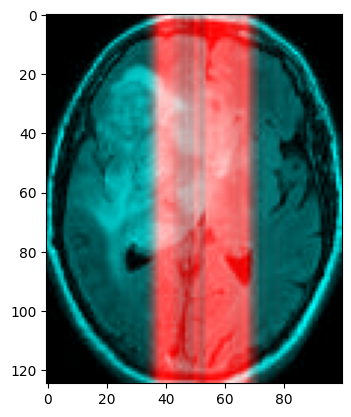

In [125]:
'''Generar un umbral para lo valores que se enecuntrar un umbral 
pormedio para los valores que se se encuentran dentrol Canal L para ajustar 
el valor de la luminosidad '''
def iluminación(imagen):
    umbralP = thresholdOtsuGris(imagen)
    escala = umbralP / 128
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            nuevo_valor = int(imagen[1][j][0] * escala)

            imagen[i][j][0] = np.clip(nuevo_valor, 0, 255)

         
    return imagen

imagen = Image.open("yes_nuevo/Y59.jpg")
imagen2  = iluminación (np.array(imagen))
plt.imshow(imagen2)
plt.show()

def conteo(imagen):
    contador = 0
    for  i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if imagen[i][j][0]>127:
                contador = contador + 1
    return contador 

def histogramaCanales (arr):
  rojos=np.zeros(256)
  verdes=np.zeros(256)
  azules=np.zeros(256)

  for k in range(arr.shape[0]):
    for c in range(arr.shape[1]):
      rojos[arr[c][k][0]] = rojos[arr[c][k][0]] + 1
      verdes[arr[c][k][1]] = verdes[arr[c][k][1]] + 1
      azules[arr[c][k][2]] = azules[arr[c][k][2]] + 1

  plt.title("Canal rojo")
  plt.stem(rojos)
  plt.show()

  plt.title("Canal verdes")
  plt.stem(verdes)
  plt.show()

  plt.title("Canal azules")
  plt.stem(azules)
  plt.show()





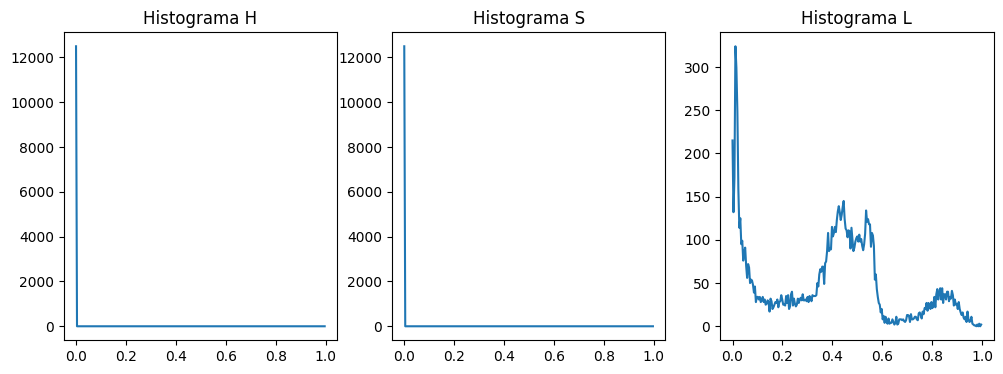

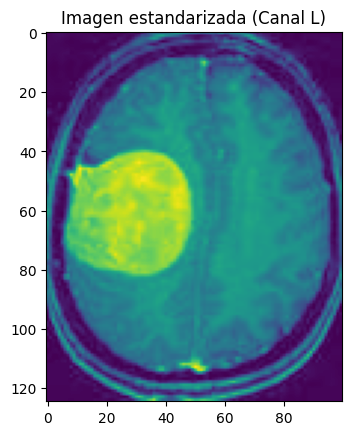

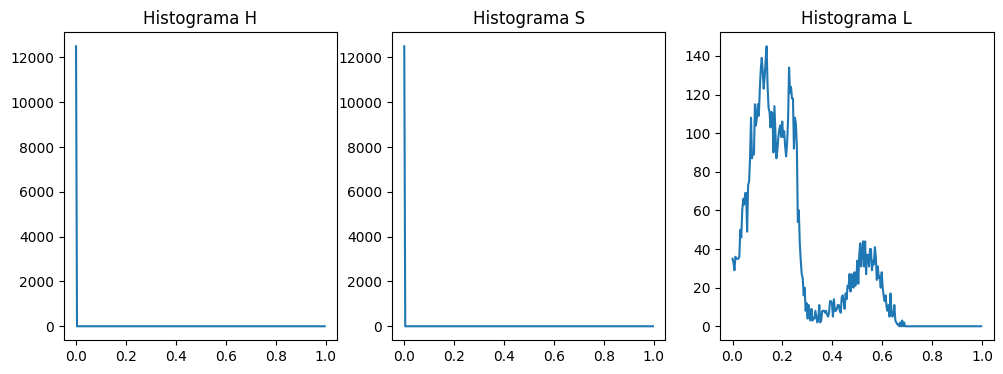

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


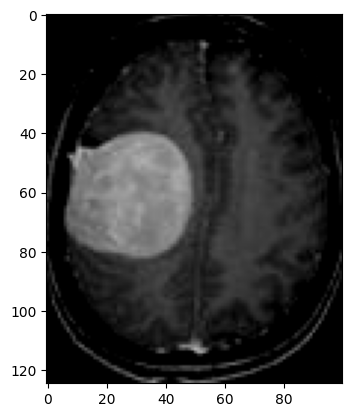

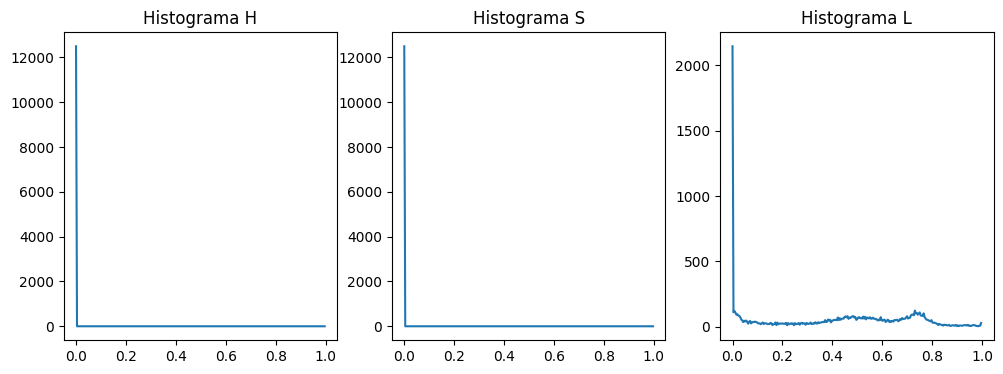

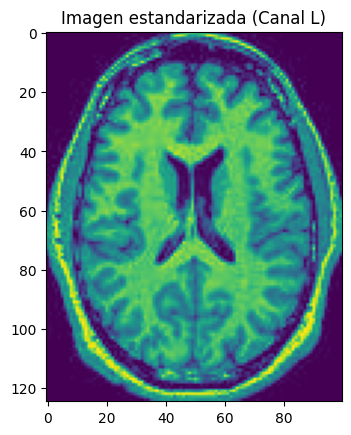

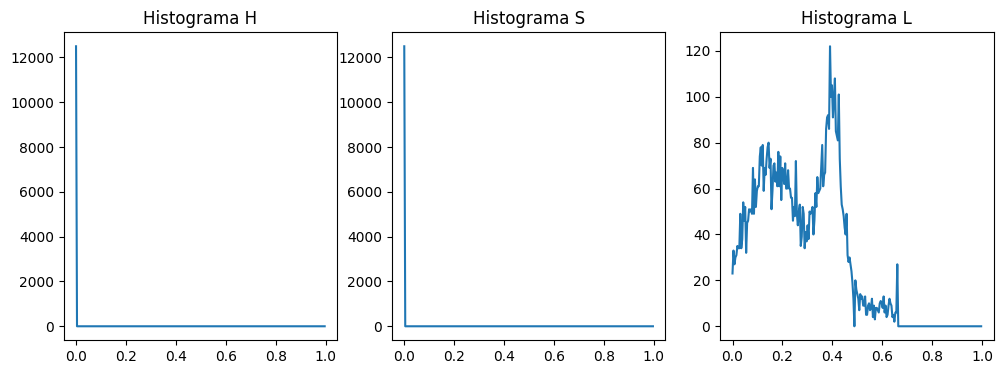

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


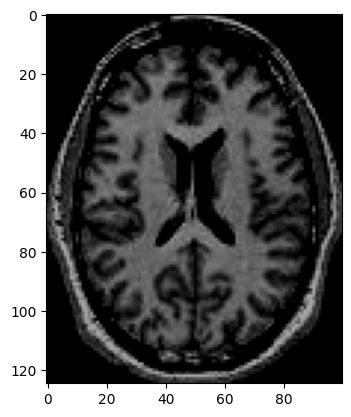

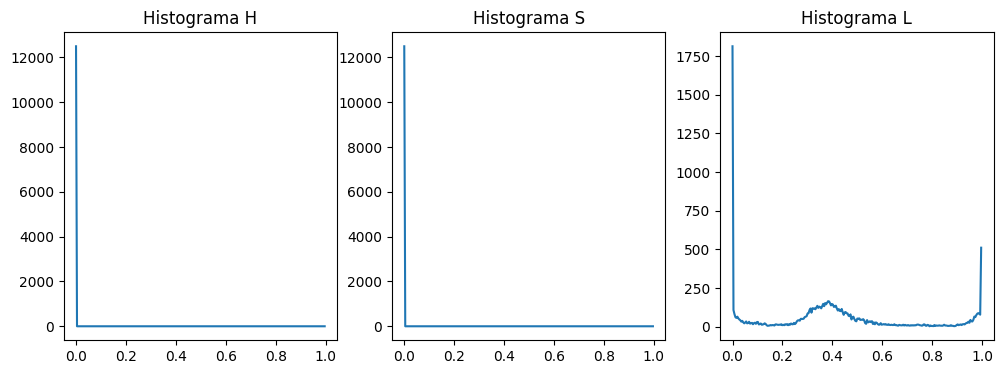

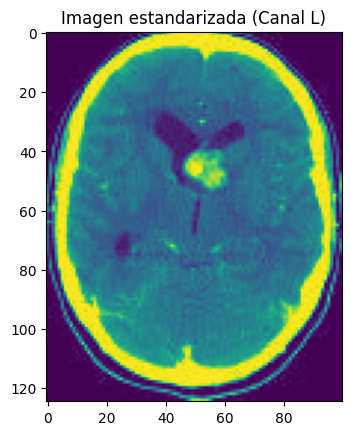

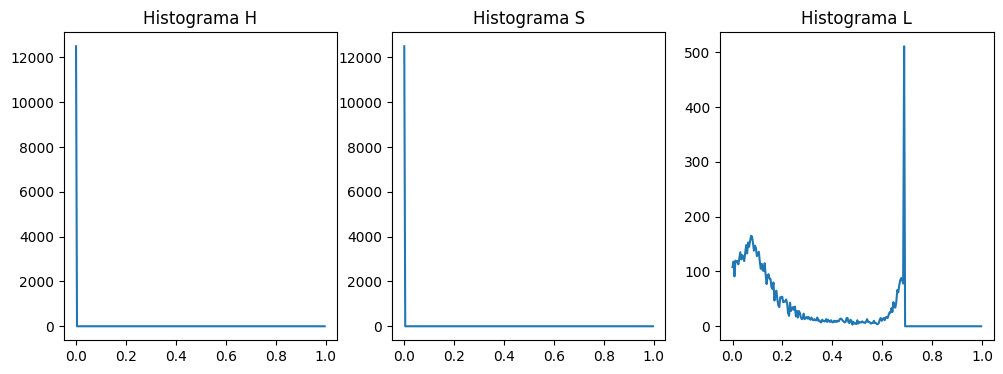

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


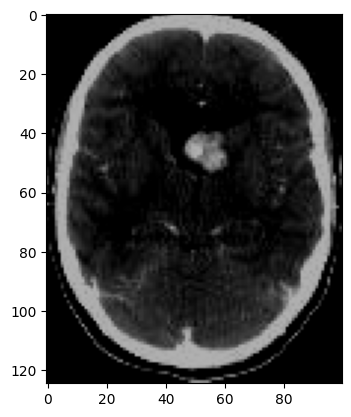

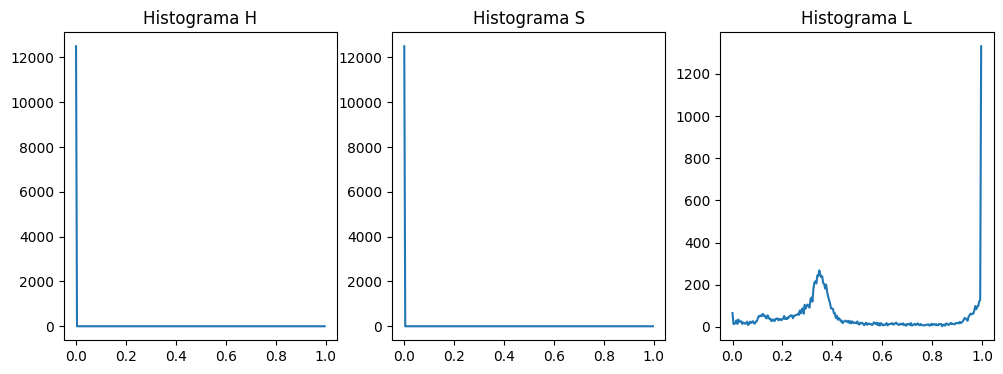

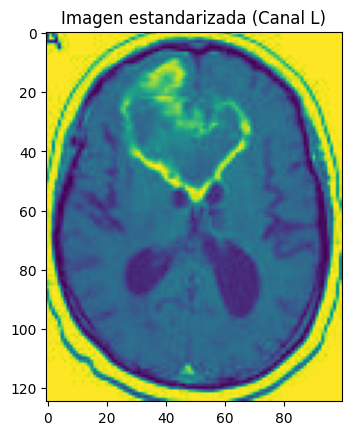

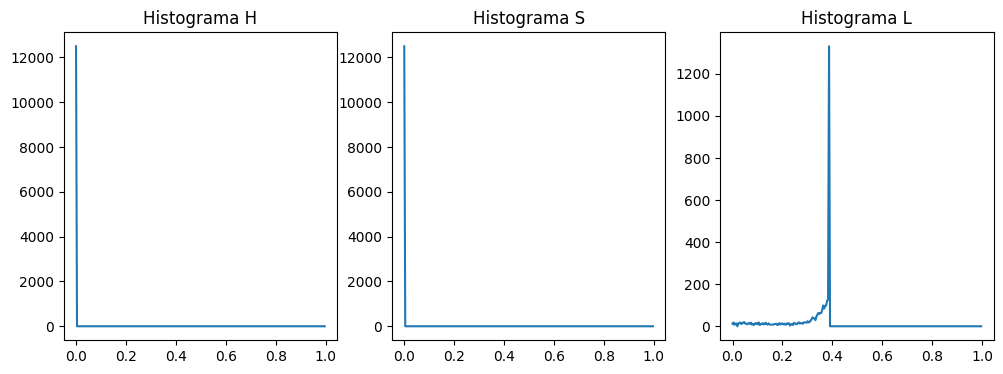

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


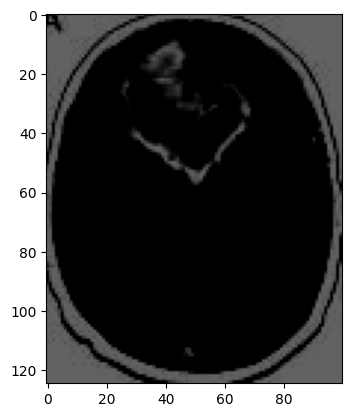

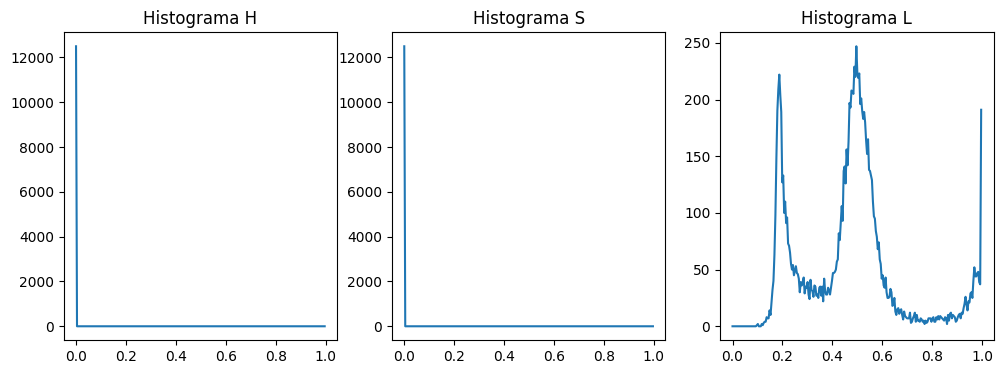

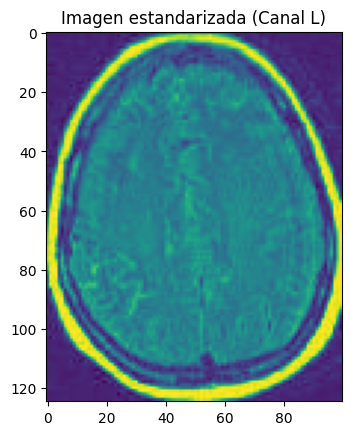

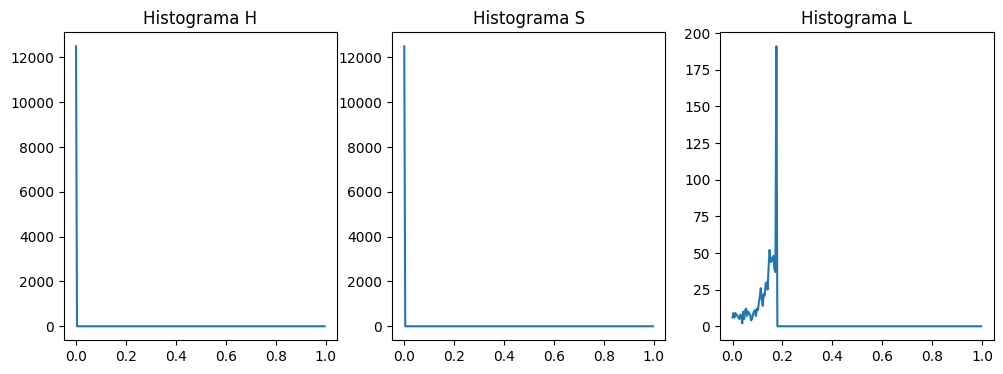

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


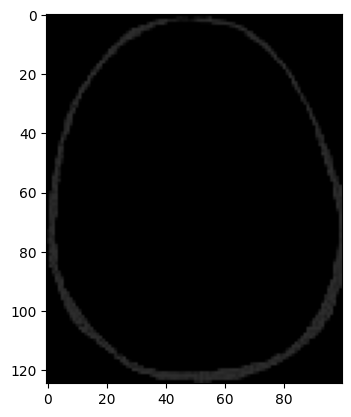

"'\nmodelo = modeloHVS(np.array(imagen))\npromedio, desvia = obtener_valor_promedio_l(np.array(imagen))\nprint(promedio, desvia)\n\nplt.imshow(modelo)\nplt.show()\n\nperfil1 = perfilado(np.array(imagen),4,1)\nplt.imshow(perfil1)\nplt.show()\nperfil2 = perfilado(np.array(imagen2),4,1)\nplt.imshow(perfil2)\nplt.show()\nhistograma(np.array(imagen))\nhistograma(iluminación(np.array(imagen)))\nhistograma(np.array(imagen3))\nhistograma(iluminación(np.array(imagen2)))\nhistograma(np.array(imagen2))\nhistograma(iluminación(np.array(imagen3)))\nhistograma(np.array(imagen4))\nhistograma(iluminación(np.array(imagen4)))\nhistograma(np.array(imagen5))\nhistograma(iluminación(np.array(imagen5)))\n\n"

In [127]:

imagen = Image.open("yes_nuevo/Y1.jpg")
imagen2 = Image.open("no_nuevo/N17.jpg")
imagen3 = Image.open("no_nuevo/N50.jpg")
imagen4 = Image.open("yes_nuevo/Y39.jpg")
imagen5 = Image.open("yes_nuevo/Y50.jpg")

histograma_canales_hsl(np.array(imagen))
otroYo = histograma_canales_hslE(np.array(imagen))
plt.imshow(otroYo)
plt.show()

histograma_canales_hsl(np.array(imagen2))
otroYo1 = histograma_canales_hslE(np.array(imagen2))
plt.imshow(otroYo1)
plt.show()

histograma_canales_hsl(np.array(imagen3))
otroYo2 = histograma_canales_hslE(np.array(imagen3))
plt.imshow(otroYo2)
plt.show()

histograma_canales_hsl(np.array(imagen4))
otroYo3 = histograma_canales_hslE(np.array(imagen4))
plt.imshow(otroYo3)
plt.show()

histograma_canales_hsl(np.array(imagen5))
otroYo4 = histograma_canales_hslE(np.array(imagen5))
plt.imshow(otroYo4)
plt.show()
''''
modelo = modeloHVS(np.array(imagen))
promedio, desvia = obtener_valor_promedio_l(np.array(imagen))
print(promedio, desvia)

plt.imshow(modelo)
plt.show()

perfil1 = perfilado(np.array(imagen),4,1)
plt.imshow(perfil1)
plt.show()
perfil2 = perfilado(np.array(imagen2),4,1)
plt.imshow(perfil2)
plt.show()
histograma(np.array(imagen))
histograma(iluminación(np.array(imagen)))
histograma(np.array(imagen3))
histograma(iluminación(np.array(imagen2)))
histograma(np.array(imagen2))
histograma(iluminación(np.array(imagen3)))
histograma(np.array(imagen4))
histograma(iluminación(np.array(imagen4)))
histograma(np.array(imagen5))
histograma(iluminación(np.array(imagen5)))

'''

In [34]:
imagen4 = iluminación(np.array(imagen4))
nombre_archivo = 'Piluminación.txt'
with open(nombre_archivo, 'w') as archivo:
    for fila in imagen4:
        linea = ' '.join(str(max(elemento)) for elemento in fila) + '\n'
        archivo.write(linea)

In [135]:
pixel = []
nombre_archivo = 'Perfilado_yes.txt'
def abrirArchivo():
    ruta_carpeta = 'C:\ProyectoImgIa\ProyectoFinalTumor\yes_nuevo'

    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir('yes_nuevo\\')
    contador = 0
    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
            contador = contador + 1
            #print(archivo)
            ruta_imagen = os.path.join('yes_nuevo/', archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_imagen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            imagen1 = perfilado(np.array(imagen),4,1)
            pixeles = blancos(imagen1)
            #print(pixeles)
            pixel.append( pixeles ) 

            with open(nombre_archivo, 'a') as archivo_salida:
                archivo_salida.write(archivo + " " + str(pixeles) + "\n")
            

abrirArchivo()

C:\Users\nanga\AppData\Local\Temp\ipykernel_14988\249813371.py:91: RuntimeWarning: invalid value encountered in scalar divide
  m_f = m/sum(f)


In [129]:
valor_maximo = max(pixel)
print(valor_maximo)
valor_minimo = min(pixel)
print(valor_minimo)

6462
312


In [137]:
pixel_no = []
nombre_archivo = 'Perfilado_no.txt'
def abrirArchivo():
    ruta_carpeta = 'C:\ProyectoImgIa\ProyectoFinalTumor\no_nuevo_'

    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir('no_nuevo\\')
    contador = 0
    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
            contador = contador + 1
            #print(archivo)
            ruta_imagen = os.path.join('no_nuevo/', archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_imagen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            imagen1 = perfilado(np.array(imagen),4,1)
            pixeles = blancos(imagen1)
            #print(pixeles)
            pixel_no.append( pixeles ) 

            with open(nombre_archivo, 'a') as archivo_salida:
                archivo_salida.write(archivo + " " + str(pixeles) + "\n")

            
        
abrirArchivo()

C:\Users\nanga\AppData\Local\Temp\ipykernel_14988\249813371.py:91: RuntimeWarning: invalid value encountered in scalar divide
  m_f = m/sum(f)


In [133]:
valor_maximo = max(pixel_no)
print(valor_maximo)
valor_minimo = min(pixel_no)
print(valor_minimo)

'''
imagen = Image.open('no_nuevo/N60.jpg')
#imagen1 = perfilado(iluminación(np.array(imagen)),4,1)
#imagen = modeloHVS(np.array(imagen))
histograma_canales_hsl(np.array(imagen))
#imagen1 = iluminación(np.array(imagen))
#imagen = perfilado(np.array(imagen),4,1)
plt.imshow(imagen, cmap="gray")
plt.show()'''



4724
79


'\nimagen = Image.open(\'no_nuevo/N60.jpg\')\n#imagen1 = perfilado(iluminación(np.array(imagen)),4,1)\n#imagen = modeloHVS(np.array(imagen))\nhistograma_canales_hsl(np.array(imagen))\n#imagen1 = iluminación(np.array(imagen))\n#imagen = perfilado(np.array(imagen),4,1)\nplt.imshow(imagen, cmap="gray")\nplt.show()'

In [134]:
pixel =  []
def abrirArchivo():
    ruta_carpeta = 'C:\ProyectoImgIa\ProyectoFinalTumor\yes_nuevo'

    # Obtener la lista de archivos en la carpeta
    archivos = os.listdir('yes_nuevo\\')
    contador = 0
    # Iterar sobre cada archivo en la carpeta
    for archivo in archivos:
            contador = contador + 1
            #print(archivo)
            ruta_imagen = os.path.join('yes_nuevo/', archivo)

            # Abrir la imagen utilizando PIL/Pillow
            imagen = Image.open(ruta_imagen)
            if imagen.mode != 'RGB':
                # Convertir la imagen a RGB si no tiene 3 canales
                imagen = imagen.convert('RGB')
            
            
            imagen1 = perfilado(iluminación(np.array(imagen)),4,1)
            pixeles = blancos(imagen1)
            pixel.append( pixeles ) 

            '''
            imagen = suavizado(np.array(imagen))
            histograma_canales_hsl(imagen)
            #print(pixeles)
            with open(nombre_archivo, 'a') as archivo_salida:
                archivo_salida.write(archivo + " " + str(pixeles) + "\n")
            '''
abrirArchivo()

C:\Users\nanga\AppData\Local\Temp\ipykernel_11564\863343401.py:91: RuntimeWarning: invalid value encountered in scalar divide
  m_f = m/sum(f)


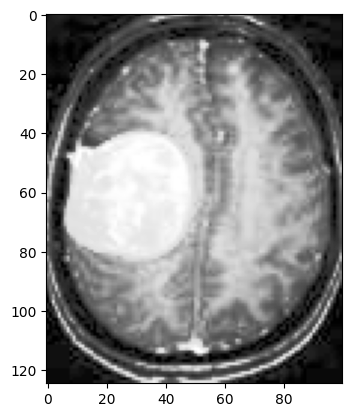

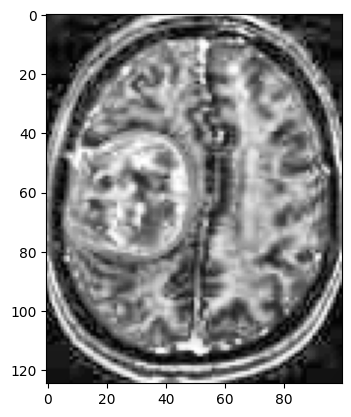

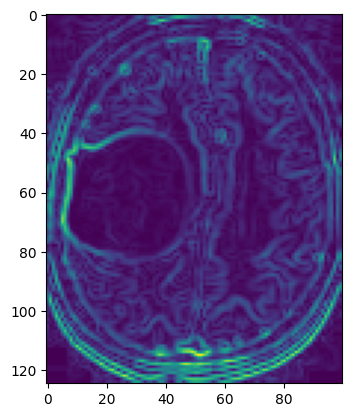

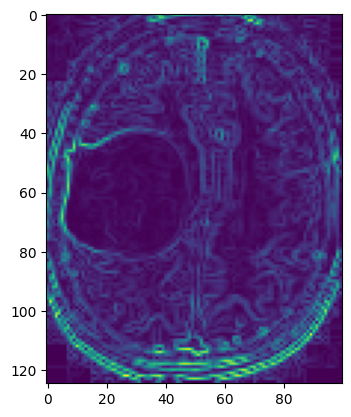

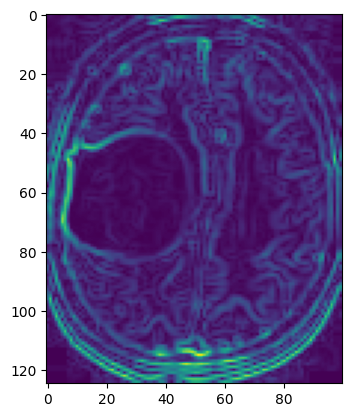

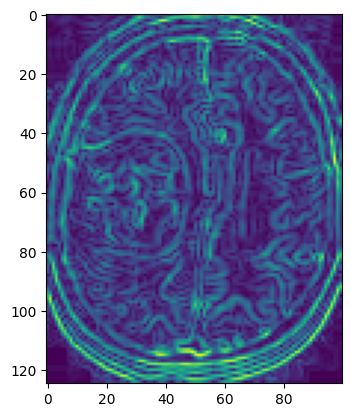

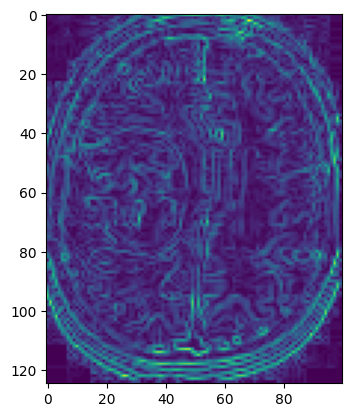

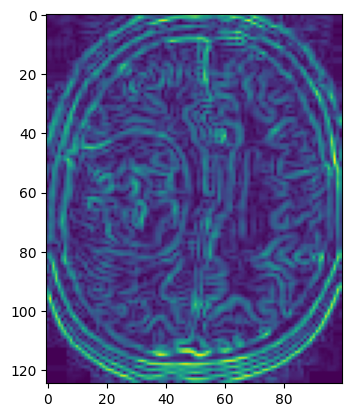

In [119]:
from skimage import exposure
from skimage import filters
from skimage.color import rgb2gray
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

imagen = io.imread("yes_nuevo/Y1.jpg", "L")

# Estiramiento de contraste
p2, p98 = np.percentile(imagen, (20,80))
img_rescale = exposure.rescale_intensity(imagen, in_range=(p2,p98))

# Ecualización
img_eq = exposure.equalize_hist(imagen)

# Ecualización adaptiva
img_adapteq = exposure.equalize_adapthist(imagen, clip_limit=0.03)

for eq in (img_eq, img_adapteq):
    plt.imshow(eq, cmap= "gray")
    plt.show()

#imagen_g = rgb2gray(img_adapteq)

# Filtros: sobel, roberts, prewitt
filtros = [filters.sobel, filters.roberts, filters.prewitt]
for filtro in filtros:
    # Aplicamos cada uno de los filtros
    img_ = filtro(img_eq)
    plt.imshow(img_)
    plt.show()
    

for filtro in filtros:
    # Aplicamos cada uno de los filtros
    img_fil = filtro(img_adapteq)
    
    # Mostramos los resultados 
    
    plt.imshow(img_fil)
    plt.show()

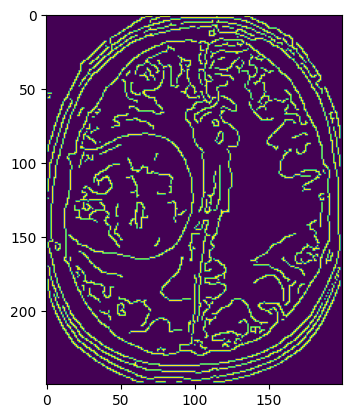

In [19]:
from skimage import io
from skimage import feature
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

imagen = io.imread("yes/Y1.jpg")
img = rgb2gray(imagen)
edge = feature.canny(img)
plt.imshow(edge)
plt.show()

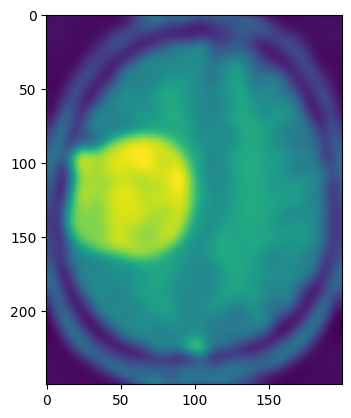

In [20]:
from skimage import restoration
from scipy.signal import convolve2d
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt

imagen = io.imread("yes/Y1.jpg")

img = rgb2gray(imagen)

psf = np.ones((5,5)) / 25

img = convolve2d(img, psf, 'same')
img += 0.1 * img.std() * np.random.standard_normal((img.shape))
deconvolved_img = restoration.wiener(img, psf, 100)

plt.imshow(deconvolved_img)
plt.show()

C:\Users\nanga\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3505: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


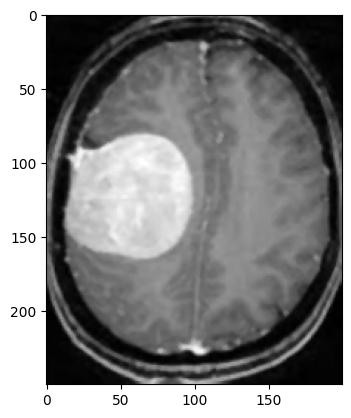

In [22]:
from skimage import io
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

imagen = io.imread("yes/Y1.jpg")
img_gray = rgb2gray(imagen)

med = median(img_gray)

plt.imshow(med, cmap= "gray")
plt.show()

In [ ]:
from skimage import exposure
from skimage import filters
from skimage.color import rgb2gray
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

imagen = io.imread("yes_nuevo_sinr/Y1.jpg", "L")

# Estiramiento de contraste
p2, p98 = np.percentile(imagen, (20,80))
img_rescale = exposure.rescale_intensity(imagen, in_range=(p2,p98))

# Ecualización
img_eq = exposure.equalize_hist(imagen)

# Ecualización adaptiva
img_adapteq = exposure.equalize_adapthist(imagen, clip_limit=0.03)

for eq in (img_eq, img_adapteq):
    plt.imshow(eq, cmap= "gray")
    plt.show()

#imagen_g = rgb2gray(img_adapteq)

# Filtros: sobel, roberts, prewitt
filtros = [filters.sobel, filters.roberts, filters.prewitt]
for filtro in filtros:
    # Aplicamos cada uno de los filtros
    img_ = filtro(img_eq)
    plt.imshow(img_)
    plt.show()
    

for filtro in filtros:
    # Aplicamos cada uno de los filtros
    img_fil = filtro(img_adapteq)
    
    # Mostramos los resultados 
    
    plt.imshow(img_fil)
    plt.show()

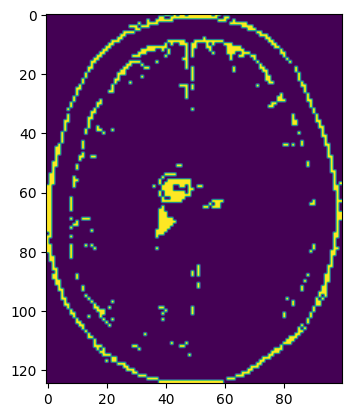

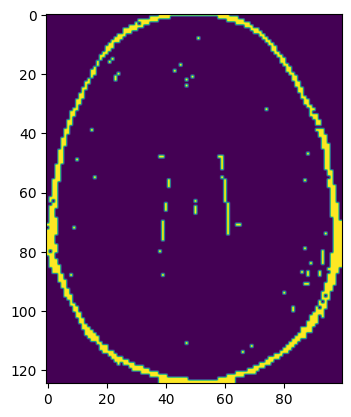

1367


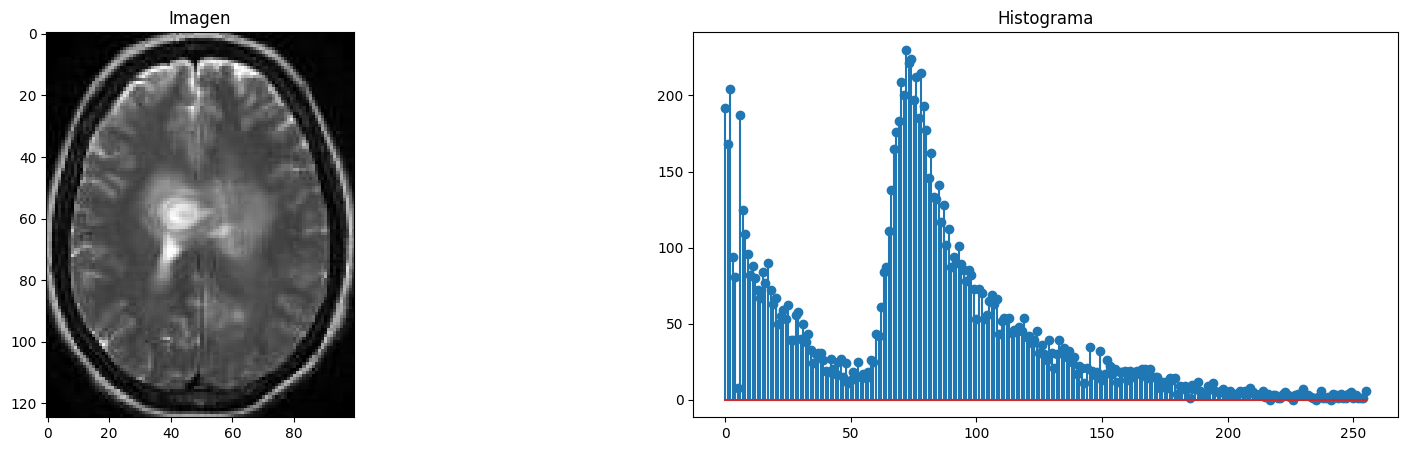

1580


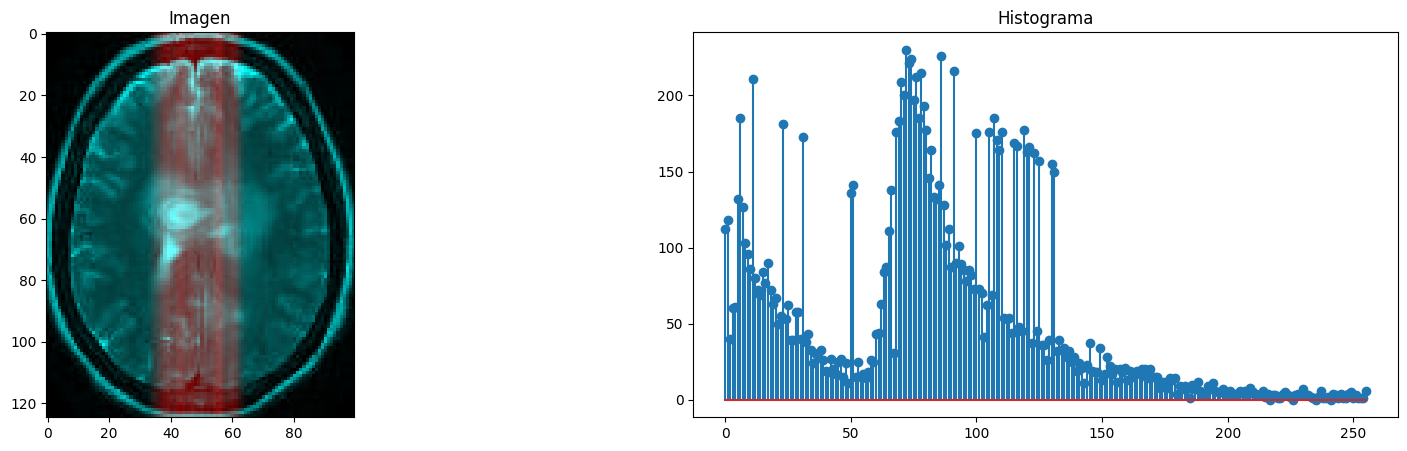

742


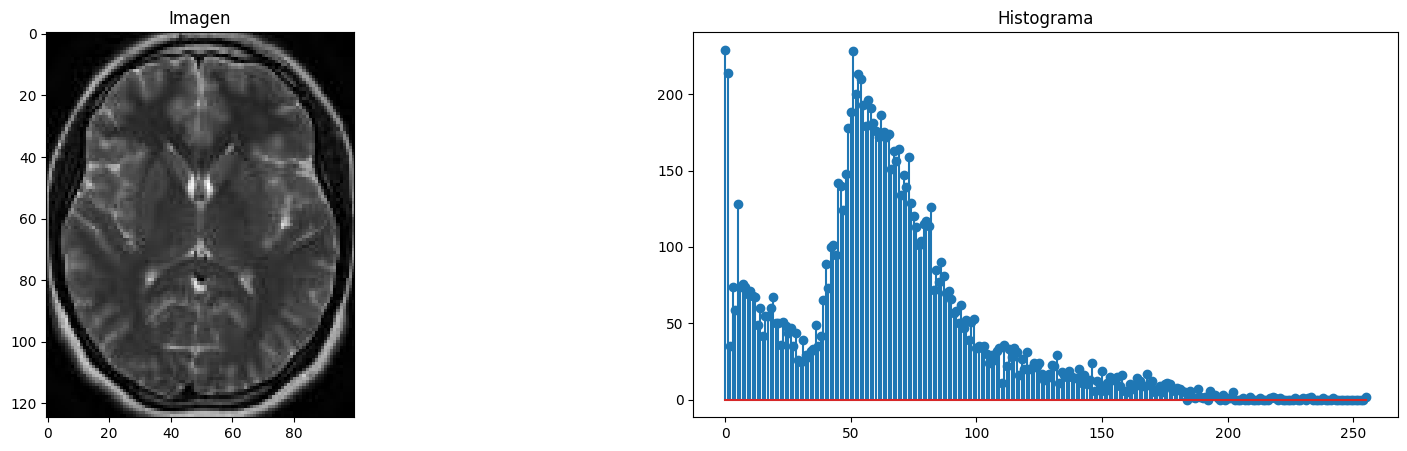

2087


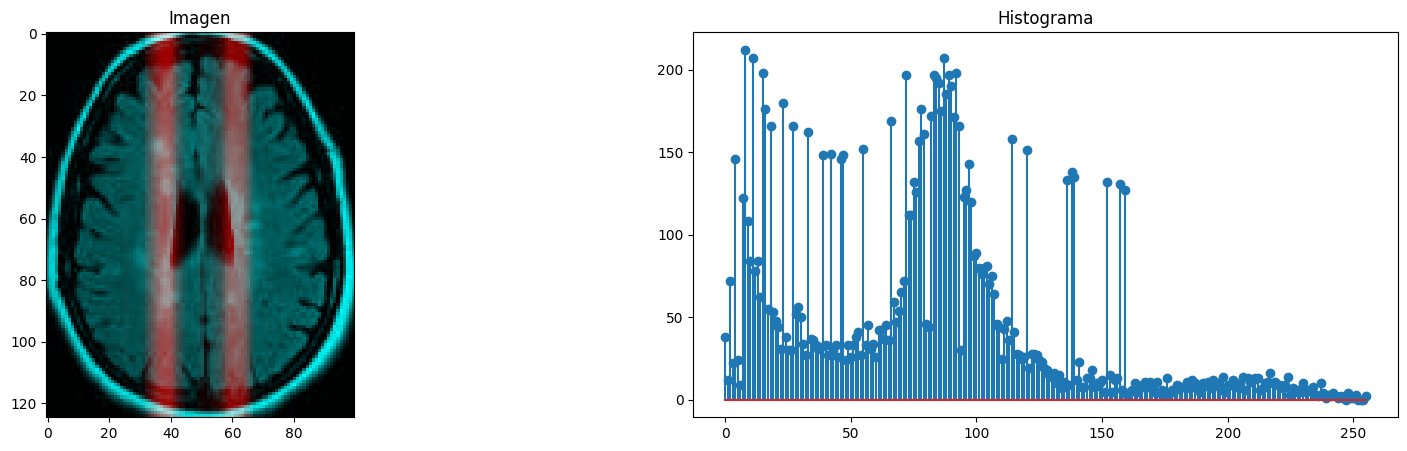

1045


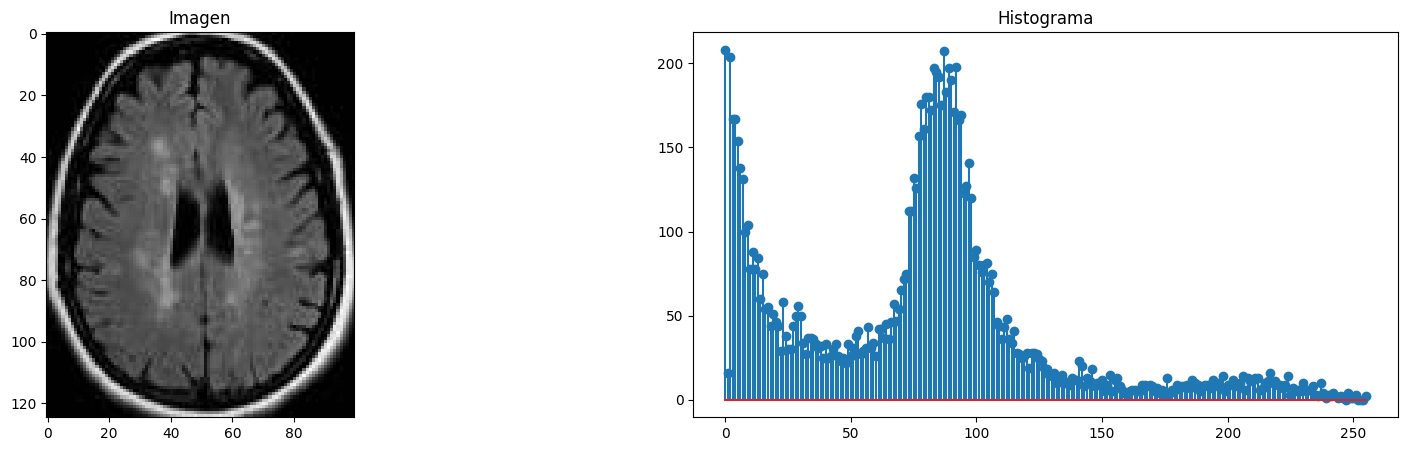

742


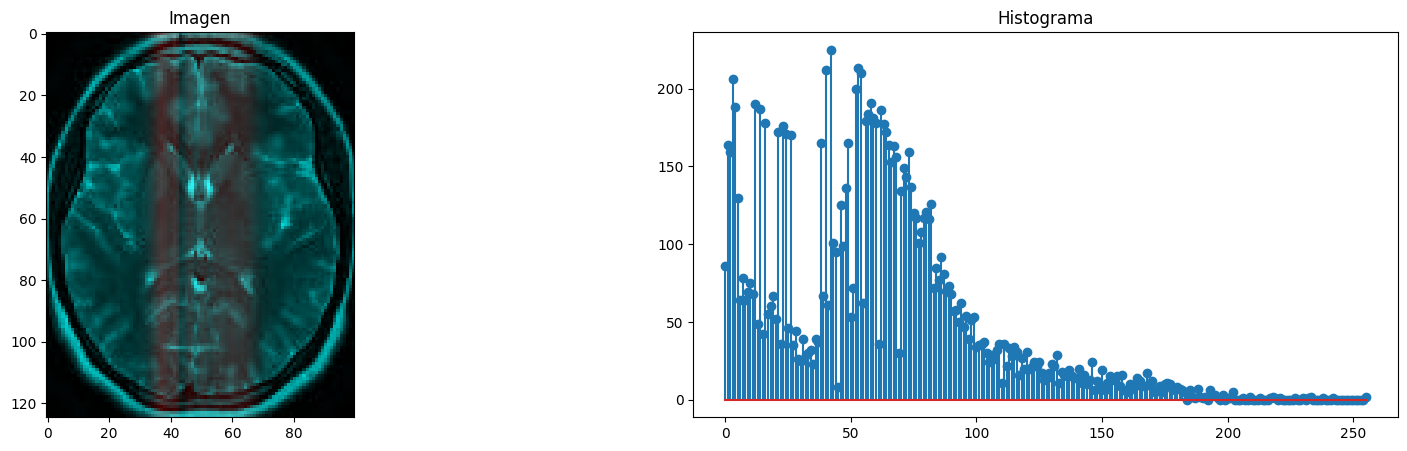

3891


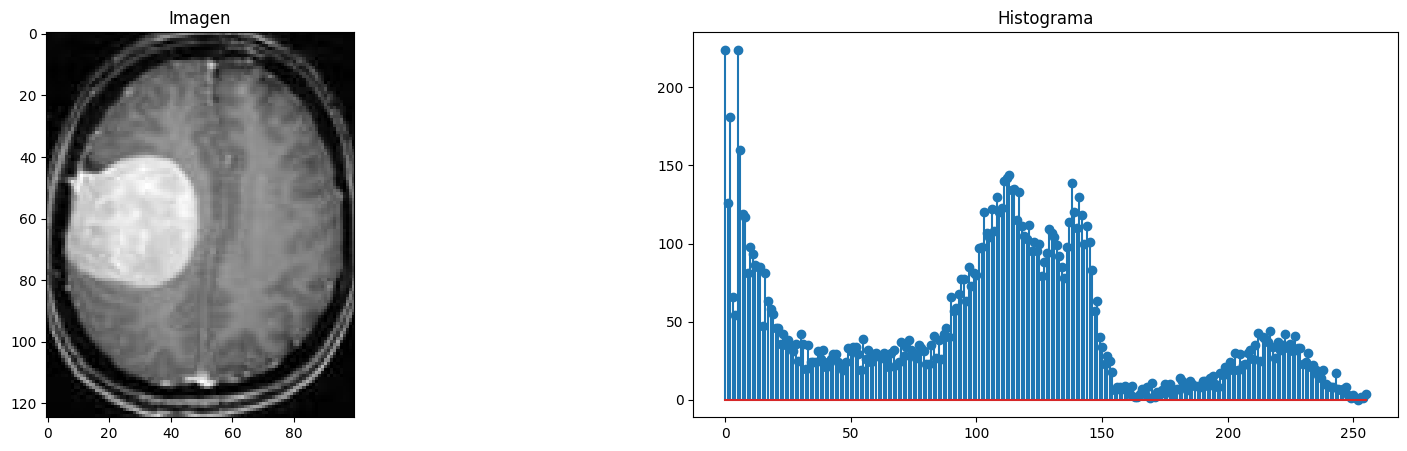

4218


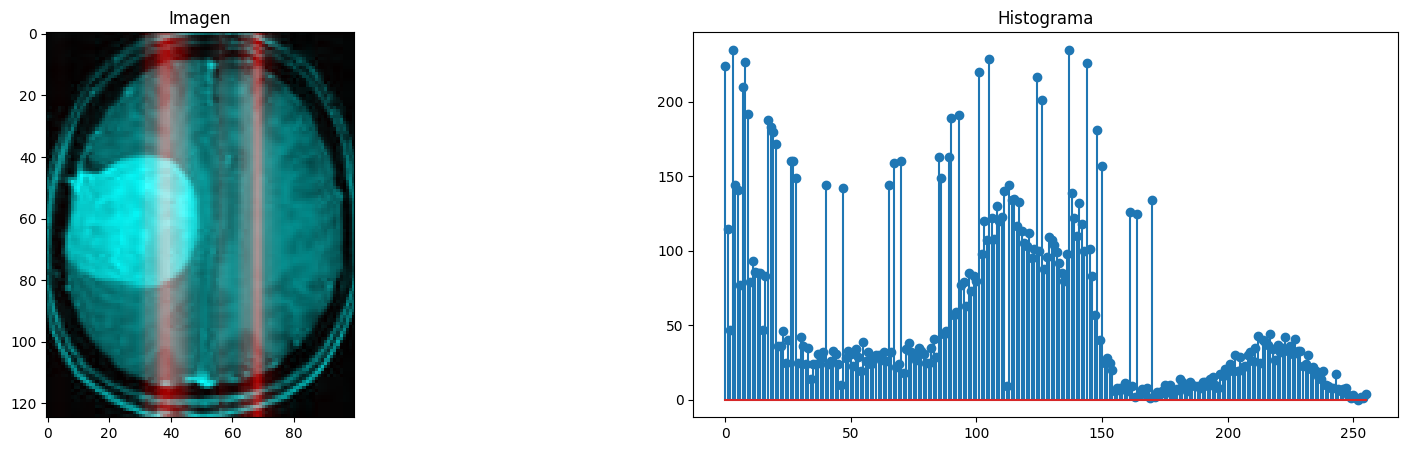

2649


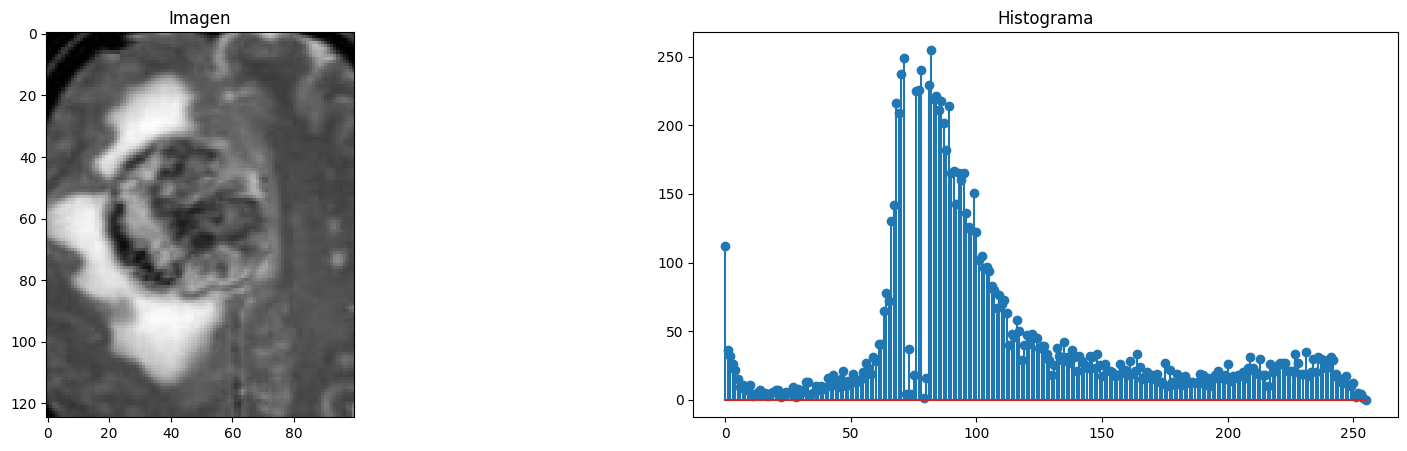

4799


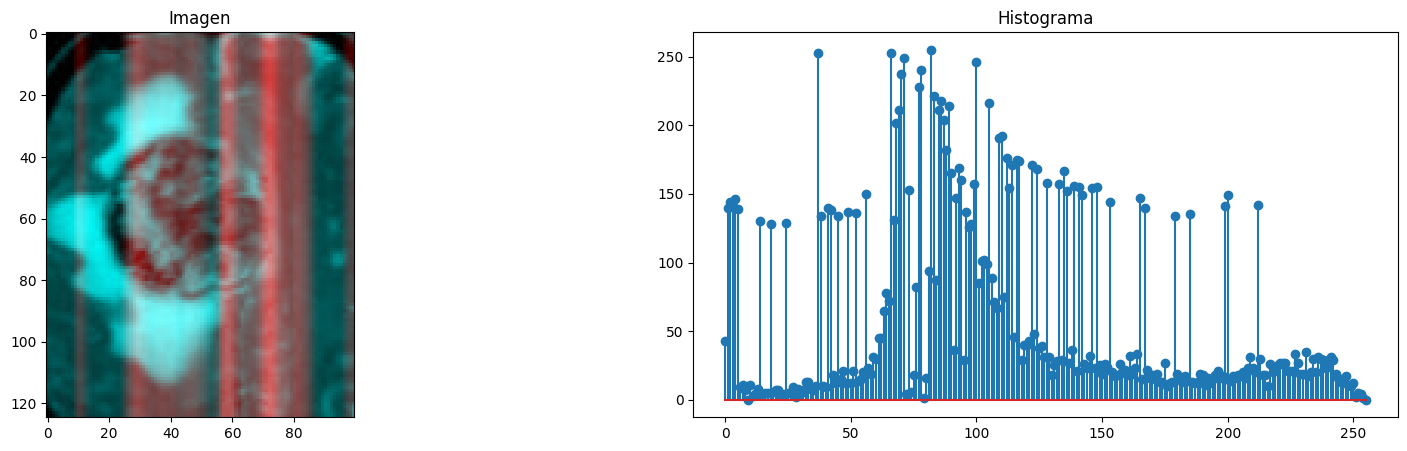

4799

In [44]:

imagen = Image.open("yes_nuevo_sinr/Y139.jpg")
imagen2 = Image.open("no_nuevo_sinr/N5.jpg")
imagen3 = Image.open("no_nuevo_sinr/N43.jpg")
imagen4 = Image.open("yes_nuevo_sinr/Y1.jpg")
imagen5 = Image.open("yes_nuevo_sinr/Y20.jpg")

perfil1 = perfilado(np.array(imagen),4,1)
plt.imshow(perfil1)
plt.show()
perfil2 = perfilado(np.array(imagen2),4,1)
plt.imshow(perfil2)
plt.show()
histograma(np.array(imagen))
histograma(iluminación(np.array(imagen)))
histograma(np.array(imagen3))
histograma(iluminación(np.array(imagen2)))
histograma(np.array(imagen2))
histograma(iluminación(np.array(imagen3)))
histograma(np.array(imagen4))
histograma(iluminación(np.array(imagen4)))
histograma(np.array(imagen5))
histograma(iluminación(np.array(imagen5)))